In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import linear_model, neighbors, ensemble, naive_bayes, svm
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.over_sampling import SMOTE

import plotly
plotly.tools.set_credentials_file(username='extralime', api_key='q3tUGZrv40fkKyR4uPuL')
import plotly.plotly as py
import plotly.graph_objs as go
import colorlover as cl

from IPython.display import Image
from IPython.display import HTML

import warnings

warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')

warnings.filterwarnings(
    module='sklearn',
    action='ignore',
    message='Data with')
warnings.filterwarnings("ignore",category=DeprecationWarning)




class CustomScaler(BaseEstimator,TransformerMixin): 
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        self.scaler = StandardScaler(copy,with_mean,with_std)
        self.columns = columns

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.ix[:,~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]
    
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

colors = cl.to_rgb(cl.scales['10']['div']['BrBG'])
HTML(cl.to_html( cl.scales['10']['div']['BrBG'] ))

/root/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Importing the data

In [5]:
#import the data, manage nulls and date field
df = pd.read_csv('lemon_train.csv')

In [6]:
df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [7]:
df.PurchDate = pd.to_datetime(df.PurchDate)
df['pyear'] = df['PurchDate'].dt.year.astype(int)
df['pmonth'] = df['PurchDate'].dt.month.astype(int)
df['pday'] = df['PurchDate'].dt.day.astype(int)
#Drop the date and other columns
df.drop(['RefId', 'BYRNO', 'AUCGUART', 'PRIMEUNIT',
         'VNZIP1','WheelType', 'VehYear','PurchDate'],1,inplace=True)


In [8]:
dnull = df.isnull().sum()
dnullsearch = dnull[dnull>500]
for i in dnullsearch.index:
    comp = df.loc[(df[i].isnull())&(df.IsBadBuy == 1)]
    print(i)
    print('Number of missing lemons: {}'.format(len(comp)))

Trim
Number of missing lemons: 374
WheelTypeID
Number of missing lemons: 2236


If we drop the nulls now, we would lose 2236 lemons, this could negatively impact the model

In [9]:
#Fill missing with most common type
df = df.fillna(df['WheelTypeID'].value_counts().index[0])
df = df.fillna(df['Trim'].value_counts().index[0])

In [10]:
df.dropna(inplace=True)
#add 1 to vehicle age (for math)
df.VehicleAge = [x+1 for x in df.VehicleAge]

We split the date into their respective components.
 - Drop columns RefID and BYRNO as these are unique identifiers and could reduce the accuracy.
 - Drop AUGGUART and PRIMEUNIT for missing data (mostly null)
 - Drop VNZIP,WheelType,VehYear, PurchDate as there are other featers in the data to respresent them
 - Fill missing WheelType ID with most common in the set
 - Drop nulls
 - Add 1 year to vehicle age. mathematical convenienve.

In [11]:
print(df.shape)
df.head(3)

(72983, 29)


,IsBadBuy,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,pyear,pmonth,pday
0,0,ADESA,4,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,...,8552.0,11597.0,12409.0,FL,7100.0,0,1113,2009,12,7
1,0,ADESA,6,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,...,9222.0,11374.0,12791.0,FL,7600.0,0,1053,2009,12,7
2,0,ADESA,5,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,...,5557.0,7146.0,8702.0,FL,4900.0,0,1389,2009,12,7


## Feature Engineering

In [12]:
#Separate and combine columns of interest
models = df.Model
submods = df.SubModel
trims = df.Trim
chars = df[['Model','SubModel','Trim']] 
chars.head(3)

,Model,SubModel,Trim
0,MAZDA3,4D SEDAN I,i
1,1500 RAM PICKUP 2WD,QUAD CAB 4.7L SLT,ST
2,STRATUS V6,4D SEDAN SXT FFV,SXT


In [13]:
#create keyword list for model characteristics
mod_chars = ['2WD','V6','4C','PICKUP','6C','FWD',
             '4WD','AWD','SFI','EFI','DOHC','I4','MPI']

#create keyowrd list for submodel characteristics
submod_chars = ['SEDAN','4D','EXT','CAB','2D','CAB','WAGON',
                'REG','FFV','PASSENGER','SUV','SPORT',
                'UTILITY','QUAD','COUPE','MINIVAN','CUV']

#Create a dataframe and extract keywords from model and submodel.
sub_val_sets, mod_val_sets = pd.DataFrame(),pd.DataFrame()

for key in submod_chars:
    subs = np.where(submods.str.contains(key),1,0) #create array for dummied char prescence    
    sub_val_sets[key] = subs #insert to dataframe
for key in mod_chars:
    mods = np.where(models.str.contains(key),1,0)
    mod_val_sets[key] = mods

#combine the two characteristic sets
char_dummies = pd.concat([mod_val_sets,sub_val_sets],axis=1)  

#remove engine displacement size
displacement = chars.SubModel.str.split('.').reset_index()


#Only keep entries with engine size len(Submodel) == 2
disp_ok = []
modls = list(displacement.SubModel.dropna())
for i in modls:
    if len(i) == 2:
        disp_ok.append(i)
        
#Finally take the last element from 1st list, insert '.' add lasr element of 2nd list
displacements = []
for i in range(len(disp_ok)):
    beg = disp_ok[i][0][-1]
    end = disp_ok[i][1][0]
    whole = beg+'.'+end
    displacements.append(whole)
displacements = pd.Series(displacements)
ds_val_cnts = displacements.value_counts().reset_index()

#create dummie matrix for engine displacements
disp_keys = pd.DataFrame()
for key in ds_val_cnts['index']:
    dsps = np.where(df.SubModel.str.contains(key),1,0) #create array for dummied char prescence    
    disp_keys[key] = dsps #insert to dataframe
char_dummies.head(3)

,2WD,V6,4C,PICKUP,6C,FWD,4WD,AWD,SFI,EFI,...,REG,FFV,PASSENGER,SUV,SPORT,UTILITY,QUAD,COUPE,MINIVAN,CUV
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [14]:
disp_keys.head(3)

,3.5,4.2,3.3,4.7,3.0,3.9,2.2,4.6,4.0,2.7,...,5.6,2.8,2.0,5.9,6.0,3.6,2.9,5.2,8.1,6.2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#Isolate continuous attributes
plodf= df[['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
 'VehicleAge','VehOdo','WarrantyCost','IsBadBuy']].copy()
plodf.dropna(inplace=True)
#transform and reduce
plodf['crcp_cacp'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRCurrentAuctionCleanPrice
plodf['crcp_cacp_war'] = plodf['crcp_cacp']* df.WarrantyCost/df.VehicleAge
plodf['log_war_age'] = df.WarrantyCost/df.VehicleAge
plodf['odo_age'] = np.log(df.VehOdo/df.VehicleAge)
        
cont_df = plodf[['odo_age','log_war_age','crcp_cacp_war']]

In [16]:
#combine the four new feature dataframes
mod_val_sets.reset_index(drop=True,inplace=True)
sub_val_sets.reset_index(drop=True,inplace=True)
disp_keys.reset_index(drop=True,inplace=True)
cont_df.reset_index(drop=True,inplace=True)

add_feats = pd.concat([mod_val_sets,sub_val_sets,disp_keys,cont_df],axis=1)

#combine new features to our existing attributes
df.reset_index(drop=True,inplace=True)
model_df = pd.concat([df,add_feats],axis=1)

#general clean up
model_df.drop(['SubModel'],1,inplace=True)
model_df.Model = model_df.Model.str.split().str[0].str.strip()
model_df.Transmission = np.where(model_df.Transmission == 'AUTO',1,0)


## Preprocessing

In [17]:
#Choose the columns to scale to avoid scaling binary data)
scale_cols = ['VehicleAge','MMRAcquisitionAuctionAveragePrice', 'VehOdo',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice','WarrantyCost','odo_age', 'log_war_age', 'crcp_cacp_war']
scale = CustomScaler(columns=scale_cols)

#Scale the model df
model_df = scale.fit_transform(model_df)

/root/.pyenv/versions/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



In [18]:
#oversample the data that the model will be trained on, test it on the other half, capture features
X = model_df.drop(['IsBadBuy'],1)
X = pd.get_dummies(X)
y = model_df.IsBadBuy
#split the data
X_train1,X_test1,y_train1,y_test1 = train_test_split(X,y,test_size=.35,random_state=43)
#smote the training set
sm = SMOTE(random_state=43,sampling_strategy=.5)

X_res, y_res = sm.fit_resample(X_train1,y_train1)

X_train2,X_test2,y_train2,y_test2 = train_test_split(X_res,y_res,test_size=.5,random_state=43)

In [102]:
rfc = ensemble.RandomForestClassifier(class_weight={0:1,1:4}, criterion='entropy', max_depth=12,
                                      min_samples_leaf=4, min_samples_split=2, n_estimators=700)

rfc.fit(X_train2,y_train2)


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 4},
            criterion='entropy', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=700, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


		Classification Report: RFC

              precision    recall  f1-score   support

           0       0.92      0.73      0.81     22462
           1       0.21      0.54      0.31      3083

   micro avg       0.70      0.70      0.70     25545
   macro avg       0.57      0.63      0.56     25545
weighted avg       0.84      0.70      0.75     25545

ROC_AUC SCORE: 0.63
Gini Index:0.2717


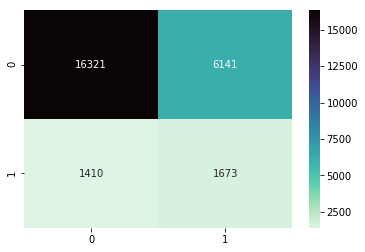

In [105]:
y_pred = rfc.predict(X_test1)
print('\n\t\tClassification Report: RFC\n')
print(classification_report(y_test1,y_pred))
print("ROC_AUC SCORE: {}".format(round(roc_auc_score(y_test1,y_pred),2)))
print('Gini Index:{}'.format(round(Gini(y_test1,y_pred),4)))
conmat = confusion_matrix(y_test1,y_pred)
sns.heatmap(conmat,annot=True,fmt='d',cmap='mako_r',cbar=True)
plt.show()

In [106]:
feature_sigs = pd.DataFrame(
    sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), 
               X.columns), reverse=True))
feature_sigs.head()
sig_feats = feature_sigs[feature_sigs[0]>0][1]


new_mod = pd.get_dummies(model_df)
target = new_mod.IsBadBuy #just in case
new_mod = new_mod[sig_feats]

In [107]:
len(new_mod.columns)

256

In [108]:
X = new_mod
y = model_df.IsBadBuy
#split the data
print(X.shape)

#smote the training set
sm = SMOTE(random_state=43,sampling_strategy=.5)

X_res, y_res = sm.fit_resample(X,y)
print(X_res.shape)

X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=.5,random_state=43)

(72983, 256)
(96010, 256)


In [ ]:
params = {'n_estimators': 700,
                      'max_depth': 12,
                      'criterion': 'entropy',
                      'min_samples_leaf':4,
                      'min_samples_split':2
                      'class_weight':'balanced'}
# Initialize and fit the model.
clf = ensemble.RandomForestClassifier(**params)
clf.fit(X_train, y_train)


		Classification Report: RFC

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     32102
           1       1.00      0.69      0.81     15903

   micro avg       0.90      0.90      0.90     48005
   macro avg       0.93      0.84      0.87     48005
weighted avg       0.91      0.90      0.89     48005

ROC_AUC SCORE: 0.84
Gini Index:0.6822


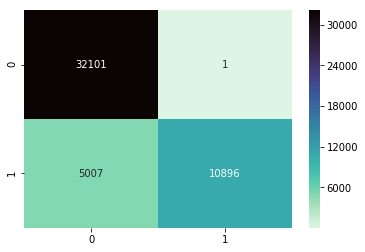

In [111]:
y_pred = clf.predict(X_test)
print('\n\t\tClassification Report: RFC\n')
print(classification_report(y_test,y_pred))
print("ROC_AUC SCORE: {}".format(round(roc_auc_score(y_test,y_pred),2)))
print('Gini Index:{}'.format(round(Gini(y_test,y_pred),4)))
conmat = confusion_matrix(y_test,y_pred)
sns.heatmap(conmat,annot=True,fmt='d',cmap='mako_r',cbar=True)
plt.show()

In [114]:
feature_sigs = pd.DataFrame(
    sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), 
               X.columns), reverse=True))
feature_sigs.head()
sig_feats = feature_sigs[feature_sigs[0]>0][1]




In [115]:
new_mod1 = pd.get_dummies(model_df)
target = new_mod1.IsBadBuy #just in case
new_mod1 = new_mod1[sig_feats]

In [116]:
X = new_mod1
y = model_df.IsBadBuy
#split the data
print(X.shape)

#smote the training set
sm = SMOTE(random_state=43,sampling_strategy=.5)

X_res, y_res = sm.fit_resample(X,y)
print(X_res.shape)

X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=.5,random_state=43)

(72983, 216)
(96010, 216)


In [117]:
params = {'n_estimators': 700,
                      'max_depth': 12,
                      'criterion': 'entropy',
                      'min_samples_leaf':2,
                      'min_samples_split':4}
# Initialize and fit the model.
clf = ensemble.RandomForestClassifier(**params)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


		Classification Report: RFC

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     32102
           1       1.00      0.69      0.81     15903

   micro avg       0.90      0.90      0.90     48005
   macro avg       0.93      0.84      0.87     48005
weighted avg       0.91      0.90      0.89     48005

ROC_AUC SCORE: 0.84
Gini Index:0.6846


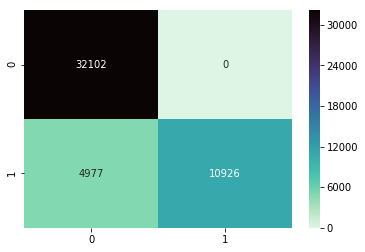

In [120]:
y_pred = clf.predict(X_test)
print('\n\t\tClassification Report: RFC\n')
print(classification_report(y_test,y_pred))
print("ROC_AUC SCORE: {}".format(round(roc_auc_score(y_test,y_pred),2)))
print('Gini Index:{}'.format(round(Gini(y_test,y_pred),4)))
conmat = confusion_matrix(y_test,y_pred)
sns.heatmap(conmat,annot=True,fmt='d',cmap='mako_r',cbar=True)
plt.show()

In [ ]:
scoring = ['precision_macro', 'recall_macro']
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)


scores = cross_validate(clf,X_res ,y_res, scoring=scoring,
                        cv=5, return_train_score=False)
sorted(scores.keys())

scores['test_recall_macro']                       


In [27]:
test_mod = model_df.drop(['Trim'],axis=1)
test_mod.drop(['6.2','8.1','3.3','6C','PICKUP'],1,inplace=True)

(96010, 437)


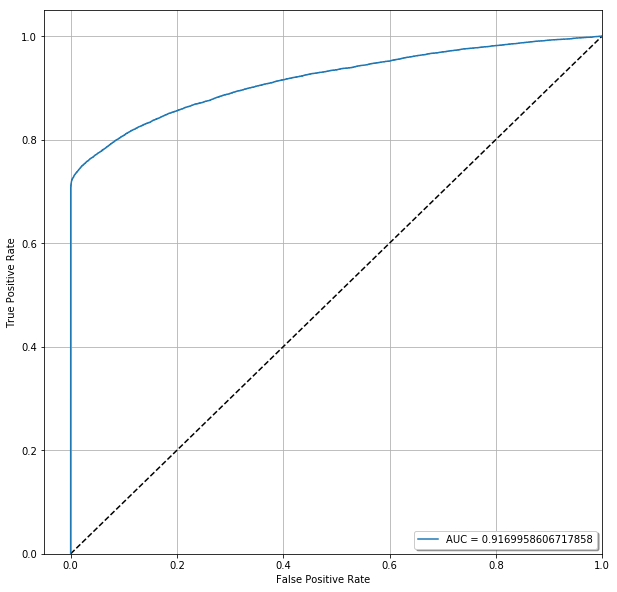

In [31]:
X = test_mod.drop(['IsBadBuy'],1)
y = test_mod.IsBadBuy
X = pd.get_dummies(X)
sm = SMOTE(random_state=43,sampling_strategy=.5)

X_res, y_res = sm.fit_resample(X,y)
print(X_res.shape)

X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=.5,random_state=43)

params = {'n_estimators': 700,
                      'max_depth': 12,
                      'loss': 'deviance',
                      'min_samples_leaf':2,
                      'min_samples_split':4}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
acc = clf.score(X_test,y_test)

# get roc/auc info
Y_score = clf.predict_proba(X_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()




		Classification Report: RFC

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     32102
           1       0.97      0.74      0.84     15903

   micro avg       0.90      0.90      0.90     48005
   macro avg       0.92      0.86      0.88     48005
weighted avg       0.91      0.90      0.90     48005

ROC_AUC SCORE: 0.86
Gini Index:0.7239


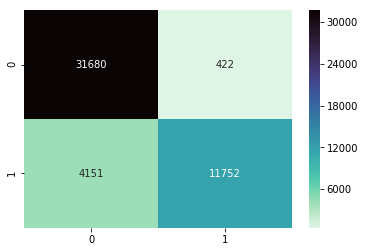

In [32]:
y_pred = clf.predict(X_test)
print('\n\t\tClassification Report: Gradient Boosting Classifier \n')
print(classification_report(y_test,y_pred))
print("ROC_AUC SCORE: {}".format(round(roc_auc_score(y_test,y_pred),2)))
print('Gini Index:{}'.format(round(Gini(y_test,y_pred),4)))
conmat = confusion_matrix(y_test,y_pred)
sns.heatmap(conmat,annot=True,fmt='d',cmap='mako_r',cbar=True)
plt.show()